In [1]:
%clear

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pickle
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.utils.data
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.classification import MulticlassAccuracy

In [2]:
with open("../data/train.pkl", "rb") as f:
    train_data = pickle.load(f)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
df = pd.DataFrame(train_data, columns = ["Sequence", "Author"])

In [5]:
df["Author"].value_counts()

Author
0    1630
1     478
3     441
4     236
2     154
Name: count, dtype: int64

In [6]:
class MusicDataset(Dataset):
    def __init__(self, X, y):
        self.X = [torch.tensor(x, dtype=torch.float32) for x in X]
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.X)

In [7]:
scaler = StandardScaler()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df["Sequence"], df["Author"], test_size = 0.2, random_state = 42)

In [9]:
X_train

456     [80.0, 80.0, 80.0, 158.0, 92.0, 92.0, 93.0, 12...
462     [0.0, 47.0, 47.0, 157.0, 28.0, 28.0, 12.0, 0.0...
2216    [-1.0, -1.0, -1.0, 0.0, 12.0, 125.0, 12.0, 12....
2668    [144.0, 144.0, 34.0, 68.0, 20.0, 32.0, 146.0, ...
381     [64.0, 64.0, 92.0, 159.0, 28.0, 47.0, 78.0, 64...
                              ...                        
1638    [-1.0, -1.0, 112.0, 0.0, 0.0, 117.0, 12.0, 12....
1095    [0.0, 82.0, 148.0, 148.0, 132.0, 3.0, 6.0, 8.0...
1130    [-1.0, -1.0, -1.0, 0.0, 5.0, 13.0, 78.0, 12.0,...
1294    [12.0, 12.0, 12.0, 12.0, 47.0, 44.0, 44.0, 44....
860     [-1.0, -1.0, 0.0, 0.0, 0.0, 13.0, 172.0, 92.0,...
Name: Sequence, Length: 2351, dtype: object

In [10]:
train_dataset = pd.concat([X_train, y_train], axis =1)
v_dataset = pd.concat([X_test, y_test], axis = 1)

In [11]:
valid_dataset = MusicDataset(v_dataset.iloc[:,0], v_dataset.iloc[:, 1])
train_dataset = MusicDataset(train_dataset.iloc[:,0], train_dataset.iloc[:, 1])

In [12]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bidirectional=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layer_dim,bidirectional=bidirectional, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim).float()
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.layer_dim * self.bidirectional, batch_size, self.hidden_dim)
        cell = torch.zeros(self.layer_dim * self.bidirectional, batch_size, self.hidden_dim)
        return hidden, cell
    
    def forward(self, x ,x_len, hidden):
        x_packed = pack_padded_sequence(x, x_len, batch_first=False, enforce_sorted=False)
        all_outputs, hidden = self.lstm(x_packed, hidden)
        preds, pred_len = pad_packed_sequence(all_outputs, batch_first=False, padding_value=0)
        x = self.fc(hidden[0][-1].float())
        return x, hidden
           
        

In [14]:
hidden_dim = 1028
layer_dim = 1
input_dim = 1
out_dim = df["Author"].nunique()
biderectional = False
model = LSTMClassifier(input_dim, hidden_dim, layer_dim, out_dim, biderectional)
model.to(device)


/root/SSNE-Pawel/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTMClassifier(
  (lstm): LSTM(1, 1028, dropout=0.3)
  (fc): Linear(in_features=1028, out_features=5, bias=True)
)

In [15]:
weights = 1.0 / torch.from_numpy(df["Author"].value_counts().values)
weights = weights / weights.sum()  
batch_size = 64
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
tested = torch.tensor([0.7, 2.2, 5.9, 2.3, 2.8])
loss_fun = nn.CrossEntropyLoss(tested.to(device))

In [16]:


pad = -10000

# Wyrównanie sekwencji w mini batch
def pad_collate(batch, pad_value=pad):
    xx, yy = zip(*batch)
    x_lens = [len(x) if x.dim() > 0 else 0 for x in xx]
    y_lens = [len(y) if y.dim() > 0 else 0 for y in yy]

    xx = [x.unsqueeze(0) if x.dim() == 0 else x for x in xx]
    yy = [y.unsqueeze(0) if y.dim() == 0 else y for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=pad_value)

    return xx_pad, yy_pad, x_lens, y_lens

In [17]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn = pad_collate)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, collate_fn = pad_collate)

In [18]:
EPOCHS_NUMBER = 100
tqdm_progress = tqdm(range(EPOCHS_NUMBER))
batch_num = 0
EPOCHS_NUMBER = 300
train_losses = []
val_losses = []
for epoch in tqdm_progress:
    train_loss = 0
    model.train()
    for x, targets, x_len, target_len in train_loader:
        optimizer.zero_grad()
        val_loss = 0
        x = x.to(device).unsqueeze(2)
        x = torch.transpose(x, 0, 1)
        targets = targets.to(device).squeeze(1)
        hidden, state = model.init_hidden(x.size(1))
        hidden, state = hidden.to(device), state.to(device)
    
        preds, _ = model(x,x_len, (hidden, state)) 
        preds = preds.squeeze(1)
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss)
    model.eval()
    with torch.no_grad():
        for x_val, targets_val, x_len_val, target_len_val in valid_loader:
            x_val = x_val.to(device).unsqueeze(2)
            x_val = torch.transpose(x_val, 0, 1)
            targets_val = targets_val.to(device).squeeze(1)
            hidden_val, state_val = model.init_hidden(x_val.size(1))
            hidden_val, state_val = hidden_val.to(device), state_val.to(device)

            preds_val, _ = model(x_val, x_len_val, (hidden_val, state_val))
            preds_val = preds_val.squeeze(1)
            loss_val = loss_fun(preds_val, targets_val)
            val_loss += loss_val.item()
    scheduler.step()
    val_losses.append(val_loss)
    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Loss in train": train_loss,
            "Loss in validation": val_loss
        }
    )

 88%|████████▊ | 88/100 [09:40<01:19,  6.60s/it, Epoch=88, Loss in train=21.8, Loss in validation=9.14]


KeyboardInterrupt: 

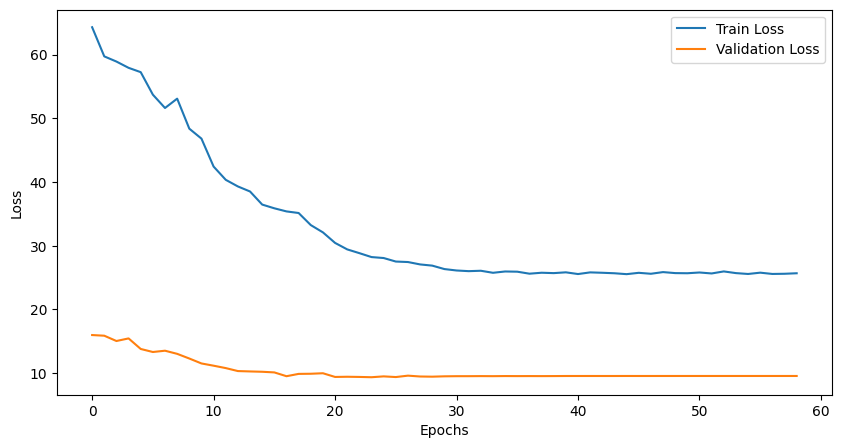

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
labels_train, labels_val = torch.tensor([], device=device), torch.tensor([], device=device)
predicted_train, predicted_val = torch.tensor([], device=device), torch.tensor([], device=device)
model.eval()
with torch.no_grad():
    for x, targets, x_len, target_len in train_loader:
        x = torch.transpose(x, 0, 1)
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device).squeeze(1)
        hidden, state = model.init_hidden(x.size(1))
        hidden, state = hidden.to(device), state.to(device)
        predicts_train, _ = model(x,x_len, (hidden, state)) 
        predicts_train = predicts_train.squeeze(1)
        predicts_train_argmax = torch.argmax(predicts_train, dim=1)
        labels_train = torch.cat((labels_train, targets))
        predicted_train = torch.cat((predicted_train, predicts_train_argmax))
    for x, targets, x_len, target_len in valid_loader:
        x = torch.transpose(x, 0, 1)
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device).squeeze(1)
        hidden, state = model.init_hidden(x.size(1))
        hidden, state = hidden.to(device), state.to(device)
        predicts_val, _ = model(x,x_len, (hidden, state)) 
        predicts_val = predicts_val.squeeze(1)
        predicts_val_argmax = torch.argmax(predicts_val, dim=1)
        labels_val = torch.cat((labels_val, targets))
        predicted_val = torch.cat((predicted_val, predicts_val_argmax))

In [ ]:
labels_train = labels_train.cpu()
predicted_train = predicted_train.cpu()
labels_val = labels_val.cpu()
predicted_val = predicted_val.cpu()


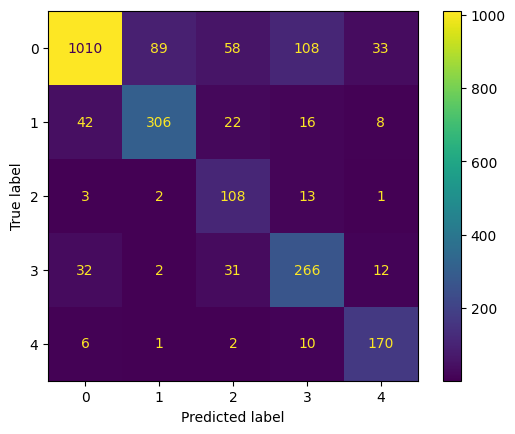

In [ ]:
confusion_matrix_train = confusion_matrix(labels_train , predicted_train)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [ ]:
f1_score(labels_train, predicted_train, average='micro')

0.7911527009783071

In [ ]:
mca_eval = MulticlassAccuracy(num_classes=5, average=None)

In [ ]:
mca_eval(predicted_train, labels_train)

tensor([0.7781, 0.7766, 0.8504, 0.7755, 0.8995])

In [ ]:
f1_score(labels_val, predicted_val, average='micro')

0.75

In [ ]:
mca_eval(predicted_val, labels_val)

tensor([0.7922, 0.6786, 0.6296, 0.7245, 0.7021])

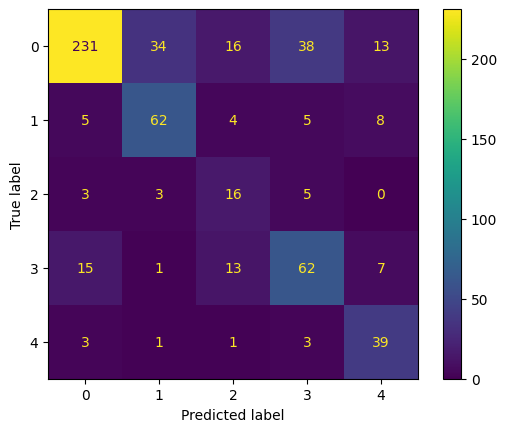

In [ ]:
confusion_matrix_val = confusion_matrix(labels_val , predicted_val)
ConfusionMatrixDisplay(confusion_matrix_val).plot()
plt.show()

In [13]:
with open("../data/test_no_target.pkl", "rb") as f:
    test_data = pickle.load(f)

In [14]:
class TestDataset(Dataset):
    def __init__(self, X):
        self.X = [torch.tensor(x, dtype=torch.float32) for x in X]

    def __getitem__(self, idx):
        return self.X[idx]

    def __len__(self):
        return len(self.X)

In [15]:
test_df = pd.DataFrame({'Sequence': test_data})

In [16]:
test_dataset = TestDataset(test_df["Sequence"].values)

In [17]:
pad = -10000

# Wyrównanie sekwencji w mini batch
def test_pad_collate(batch, pad_value=pad):
    x_lens = [len(x) if isinstance(x, torch.Tensor) and x.dim() > 0 else 0 for x in batch]
    xx = [x.unsqueeze(0) if isinstance(x, torch.Tensor) and x.dim() == 0 else x for x in batch]
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    return xx_pad, x_lens

In [18]:
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn = test_pad_collate)


In [19]:
hidden_dim = 1028
layer_dim = 1
input_dim = 1
out_dim = df["Author"].nunique()
biderectional = False
model = LSTMClassifier(input_dim, hidden_dim, layer_dim, out_dim, biderectional)
model.to(device)
model.load_state_dict(torch.load('../models/model_best.pth'))

/root/SSNE-Pawel/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [20]:
model.eval()
predicted_test = torch.tensor([], device=device)
with torch.no_grad():
    for x, x_lens in test_loader:
        x = torch.transpose(x, 0, 1)
        x = x.to(device).unsqueeze(2)
        hidden, state = model.init_hidden(x.size(1))
        hidden, state = hidden.to(device), state.to(device)
        predicts_test, _ = model(x,x_lens, (hidden, state)) 
        predicts_test = predicts_test.squeeze(1)
        predicts_test_argmax = torch.argmax(predicts_test, dim=1)
        predicted_test = torch.cat((predicted_test, predicts_test_argmax))

In [21]:
print(predicted_test)

tensor([2., 0., 1.,  ..., 4., 3., 3.], device='cuda:0')


In [23]:
df_final = pd.DataFrame(predicted_test.cpu().numpy(),dtype=int)
df.to_csv('../results/output.csv', index=False)

In [24]:
df_final[0].value_counts()

0
0    540
3    193
1    175
4    105
2     90
Name: count, dtype: int64